Schur Numbers & Grover Search

It uses proper headings, math blocks, spacing, and consistent formatting.

You can paste this directly into a Jupyter Markdown cell.

⸻

Quantum Math Challenge 4 – Schur Numbers Toy & Grover Search

Idea

Schur numbers S(k) describe how large a set
$$
\{1, 2, \dots, n\}
$$
can be colored with k colors without producing any monochromatic solution to:

x + y = z.

Known values:
- S(1) = 1,
- S(2) = 4,
- S(3) = 13,
- S(4) = 44,
- S(5) = 161,
- S(6) is unknown — the search space is astronomically large.

Computing real Schur numbers requires exploring spaces so enormous that neither classical nor current quantum computers are capable of evaluating them.

However, we can build a toy Schur challenge that demonstrates how quantum search (Grover’s algorithm) behaves on small combinatorial spaces.

⸻

Toy Problem Setup

We choose a small value of n (e.g., n=4) and restrict ourselves to 2-colorings, represented as n-bit strings.

A bitstring is considered valid if:
- all three integers $$ x, y, z \le n$$, and
- whenever x + y = z, the colors of x, y, z are not all the same.

This allows us to:
1.	Classically search all $$2^n$$ possible colorings find at least one valid Schur coloring.
2.	Take that valid coloring as our secret “good” state.
Example:
$$
[0, 1, 1, 0] \;\;\longleftrightarrow\;\; 0110
$$
3.	Use Grover’s algorithm to search for that bitstring among all 2^n colorings.
4.	Run Grover on:
   - the Aer simulator
   - optionally on IBM Quantum hardware using SamplerV2.
5.	Compare classical vs quantum:
   - number of steps,
   - success probability,
   - runtime.

This is not computing real Schur numbers;
it is a Schur-themed quantum search demonstration showing how Grover behaves in small combinatorial problems.

⸻

Theory: Why Grover Helps Here

Classically, evaluating all colorings requires:

$$
O(2^n)\ \text{checks}.
$$

Grover’s algorithm reduces this to:

$$
O(\sqrt{2^n})
\;=\;
O(2^{\,n/2})
$$

Oracle calls — a quadratic quantum speedup.

Even though we use a classical check to find a valid coloring, Grover still demonstrates:
- how quantum search scales more efficiently,
- how quantum methods can embed combinatorial constraints,
- how amplitude amplification isolates the correct solution from an unstructured space.

In [1]:
%matplotlib inline

import time
import itertools
from typing import List, Tuple

import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram

from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    SamplerV2 as Sampler,
    EstimatorV2 as Estimator,
)

IBM helpers

In [ ]:
def get_runtime_service(user_token: str = None) -> QiskitRuntimeService:
    token = user_token
    if not token:
        raise ValueError("IBM Quantum API token not provided.")
    QiskitRuntimeService.save_account(
        token=token,
        channel="ibm_cloud",
        overwrite=True,
    )
    service = QiskitRuntimeService(channel="ibm_cloud")
    print("Connected to IBM Quantum service.")
    return service


def get_backend(prefer_ibm: bool = True, min_qubits: int = 1):
    if prefer_ibm:
        try:
            user_token = "<YOUR_IBM_QUANTUM_API_TOKEN>"
            service = get_runtime_service(user_token)
            backend = service.least_busy(
                operational=True,
                simulator=False,
                min_num_qubits=min_qubits,
            )
            print(f"Using IBM backend: {backend.name}")
            return backend, "ibm"
        except Exception as e:
            print("Could not connect to IBM runtime, using AerSimulator.")
            print("Reason:", e)

    backend = AerSimulator()
    print("Using local AerSimulator backend.")
    return backend, "aer"

Classical Schur search

In [3]:
def schur_triples(n: int) -> List[Tuple[int, int, int]]:
    """
    All triples (x, y, z) with x + y = z, 1 <= x, y, z <= n.
    """
    triples = []
    for x in range(1, n + 1):
        for y in range(1, n + 1):
            z = x + y
            if 1 <= z <= n:
                triples.append((x, y, z))
    return triples


def is_schur_valid_coloring(colors: List[int], k: int, triples: List[Tuple[int, int, int]]) -> bool:
    """
    Check if a k-coloring of {1,...,n} avoids monochromatic x + y = z.
    colors[i-1] is the color of integer i.
    """
    for x, y, z in triples:
        c = colors[x - 1]
        if colors[y - 1] == c and colors[z - 1] == c:
            return False
    return True


def find_schur_valid_coloring(n: int, k: int, max_solutions: int = 1, return_steps: bool = False):
    """
    Brute-force search for Schur-valid colorings.
    Returns:
      if return_steps=False:  [colorings]
      if return_steps=True:  ([colorings], steps_checked)
    """
    triples = schur_triples(n)
    solutions = []
    steps = 0
    for assignment in itertools.product(range(k), repeat=n):
        steps += 1
        colors = list(assignment)
        if is_schur_valid_coloring(colors, k, triples):
            solutions.append(colors)
            if len(solutions) >= max_solutions:
                break
    if return_steps:
        return solutions, steps
    return solutions


def demo_classical_schur(max_n: int = 7, k: int = 2):
    print(f"Classical Schur search for k = {k}, n = 1..{max_n}")
    for n in range(1, max_n + 1):
        start = time.perf_counter()
        sols, steps = find_schur_valid_coloring(n, k, max_solutions=1, return_steps=True)
        elapsed = time.perf_counter() - start
        print(
            f"n = {n:2d} | search space size k^n = {k**n:7d} | "
            f"found_solution = {int(bool(sols)):5} | steps_checked = {steps:7d} | time = {elapsed:.6f} s"
        )
    print(
        "\nFor k=2, it is known that S(2) = 4: valid colorings exist for n <= 4, and not for n >= 5.\n"
        "For k=6 and S(6), the search space is astronomically large and not tractable."
    )

Encode coloring as bitstring (2 colors)

In [4]:
def coloring_to_int(colors: List[int]) -> int:
    """
    For 2 colors (0/1), pack colors[i] as bit i (LSB first).
    """
    x = 0
    for i, c in enumerate(colors):
        if c not in (0, 1):
            raise ValueError("This toy demo requires 2-coloring (0/1).")
        if c == 1:
            x |= (1 << i)
    return x


def int_to_bitstring(x: int, n: int) -> str:
    return format(x, f"0{n}b")

Grover oracle and diffuser for the Schur toy

In [5]:
def build_oracle_secret(secret: int, n: int) -> QuantumCircuit:
    bits = int_to_bitstring(secret, n)
    qc = QuantumCircuit(n, name="Oracle")
    for q, bit in enumerate(reversed(bits)):
        if bit == "0":
            qc.x(q)
    qc.h(n - 1)
    qc.mcx(list(range(n - 1)), n - 1)
    qc.h(n - 1)
    for q, bit in enumerate(reversed(bits)):
        if bit == "0":
            qc.x(q)
    return qc


def build_diffuser(n: int) -> QuantumCircuit:
    qc = QuantumCircuit(n, name="Diffuser")
    qc.h(range(n))
    qc.x(range(n))
    qc.h(n - 1)
    qc.mcx(list(range(n - 1)), n - 1)
    qc.h(n - 1)
    qc.x(range(n))
    qc.h(range(n))
    return qc


def build_grover_schur_toy_circuit(n: int, secret_coloring: List[int]) -> QuantumCircuit:
    """
    Build a Grover circuit that searches for a single Schur-valid coloring
    encoded as a bitstring.
    """
    if any(c not in (0, 1) for c in secret_coloring):
        raise ValueError("Need a 2-color (0/1) coloring.")
    N = 2**n
    iterations = int(np.floor(np.pi / 4 * np.sqrt(N)))

    secret_int = coloring_to_int(secret_coloring)
    oracle = build_oracle_secret(secret_int, n)
    diffuser = build_diffuser(n)

    qc = QuantumCircuit(n)
    qc.h(range(n))
    for _ in range(iterations):
        qc.append(oracle, range(n))
        qc.append(diffuser, range(n))
    qc.measure_all()
    return qc, iterations

Run Grover Schur toy on sim / IBM

In [ ]:
def run_grover_schur_toy(n: int, shots: int, use_ibm: bool = False):
    print(f"Searching for a 2-color Schur-valid coloring for n={n} classically...")
    sols, classical_steps = find_schur_valid_coloring(n, k=2, max_solutions=1, return_steps=True)
    if not sols:
        print("No valid 2-coloring found; choose smaller n.")
        return

    secret_coloring = sols[0]
    print("Found a valid coloring (0/1 for numbers 1..n):", secret_coloring)
    print(f"Classical search checked {classical_steps} colorings (out of {2**n} possible).")

    secret_int = coloring_to_int(secret_coloring)
    secret_str = int_to_bitstring(secret_int, n)
    print(f"Encoded as bitstring (LSB=number 1): {secret_str} (int = {secret_int})")

    qc, grover_iters = build_grover_schur_toy_circuit(n, secret_coloring)
    print("\nGrover circuit:")
    print(qc.draw())

    N = 2**n
    print(f"\nTheoretical Grover iterations: {grover_iters} (vs {N} classical checks)")

    # Simulator
    backend_sim, _ = get_backend(prefer_ibm=False, min_qubits=n)
    pm_sim = generate_preset_pass_manager(backend=backend_sim, optimization_level=1)
    isa_qc_sim = pm_sim.run(qc)

    print("\n[Grover on simulator]...")
    t_start = time.perf_counter()
    job_sim = backend_sim.run(isa_qc_sim, shots=shots)
    result_sim = job_sim.result()
    counts_sim = result_sim.get_counts()
    t_sim = time.perf_counter() - t_start
    p_success_sim = counts_sim.get(secret_str, 0) / shots
    print(f"  Success (sim): {p_success_sim:.3f}, time = {t_sim:.6f} s")
    plot_histogram(counts_sim, title="Schur-Grover — simulator")

    # IBM
    t_ibm = None
    p_success_ibm = None
    if use_ibm:
        print("\n[Grover on IBM Quantum]...")
        backend_ibm, kind = get_backend(prefer_ibm=True, min_qubits=n)
        if kind == "aer":
            print("IBM backend not available, staying on simulator.")
        else:
            pm_ibm = generate_preset_pass_manager(backend=backend_ibm, optimization_level=1)
            isa_qc_ibm = pm_ibm.run(qc)
            sampler = Sampler(mode=backend_ibm)
            sampler.options.default_shots = shots
            t_start = time.perf_counter()
            job_ibm = sampler.run([isa_qc_ibm], shots=shots)
            pub = job_ibm.result()[0]
            counts_ibm = pub.join_data().get_counts()
            t_ibm = time.perf_counter() - t_start
            p_success_ibm = counts_ibm.get(secret_str, 0) / shots
            print(f"  Success (IBM): {p_success_ibm:.3f}, time = {t_ibm:.6f} s")
            plot_histogram(counts_ibm, title="Schur-Grover — IBM backend")

    labels_time = ["Simulator"]
    values_time = [t_sim]
    if t_ibm is not None:
        labels_time.append("IBM")
        values_time.append(t_ibm)

    plt.figure()
    plt.bar(labels_time, values_time)
    plt.ylabel("Time (seconds)")
    plt.title("Runtime: Grover Schur-toy simulator vs IBM")
    plt.show()

    plt.figure()
    plt.bar(["Classical checks (2^n)", "Grover iterations"], [2**n, grover_iters])
    plt.ylabel("Number of steps / checks")
    plt.title("Steps: classical coloring search vs Grover")
    plt.show()

    print("\n=== Summary ===")
    print(f"Secret coloring: {secret_coloring} (bitstring {secret_str})")
    print(f"Classical: checked {classical_steps} colorings (out of {2**n}), O(2^n) steps.")
    print(f"Grover:    iterations ≈ {grover_iters}, measurements = {shots}")
    print(f"Simulator: p_success = {p_success_sim:.3f}, time = {t_sim:.6f} s")
    if t_ibm is not None:
        print(f"IBM:       p_success = {p_success_ibm:.3f}, time = {t_ibm:.6f} s")

Interactive driver

In [7]:
def schur_grover_interactive():
    print("=== Schur-Grover Toy Challenge ===")
    demo_str = input("Show classical Schur demo for n=1..7, k=2? (y/n, default y): ").strip().lower()
    if demo_str in ("", "y"):
        demo_classical_schur(max_n=7, k=2)

    n_str = input("\nChoose n for Grover (e.g., 3 or 4): ").strip()
    try:
        n = int(n_str)
        if n < 2 or n > 6:
            raise ValueError
    except ValueError:
        print("Using n = 3.")
        n = 3

    shots_str = input("Number of shots (default 2048): ").strip()
    try:
        shots = int(shots_str) if shots_str else 2048
    except ValueError:
        shots = 2048

    use_ibm_str = input("Also run Grover on IBM Quantum? (y/n): ").strip().lower()
    use_ibm = use_ibm_str == "y"

    run_grover_schur_toy(n=n, shots=shots, use_ibm=use_ibm)

=== Schur-Grover Toy Challenge ===
Classical Schur search for k = 2, n = 1..7
n =  1 | search space size k^n =       2 | found_solution =     1 | steps_checked =       1 | time = 0.000009 s
n =  2 | search space size k^n =       4 | found_solution =     1 | steps_checked =       2 | time = 0.000005 s
n =  3 | search space size k^n =       8 | found_solution =     1 | steps_checked =       3 | time = 0.000004 s
n =  4 | search space size k^n =      16 | found_solution =     1 | steps_checked =       7 | time = 0.000004 s
n =  5 | search space size k^n =      32 | found_solution =     0 | steps_checked =      32 | time = 0.000011 s
n =  6 | search space size k^n =      64 | found_solution =     0 | steps_checked =      64 | time = 0.000020 s
n =  7 | search space size k^n =     128 | found_solution =     0 | steps_checked =     128 | time = 0.000039 s

For k=2, it is known that S(2) = 4: valid colorings exist for n <= 4, and not for n >= 5.
For k=6 and S(6), the search space is astronomi

qiskit_runtime_service.__init__:WARNING:2025-11-17 10:39:30,467: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: new_instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().


Connected to IBM Quantum service.


qiskit_runtime_service.backends:WARNING:2025-11-17 10:39:31,358: Loading instance: new_instance, plan: open
qiskit_runtime_service.backends:WARNING:2025-11-17 10:39:33,352: Using instance: new_instance, plan: open


Using IBM backend: ibm_torino
  Success (IBM): 0.432, time = 5.065014 s


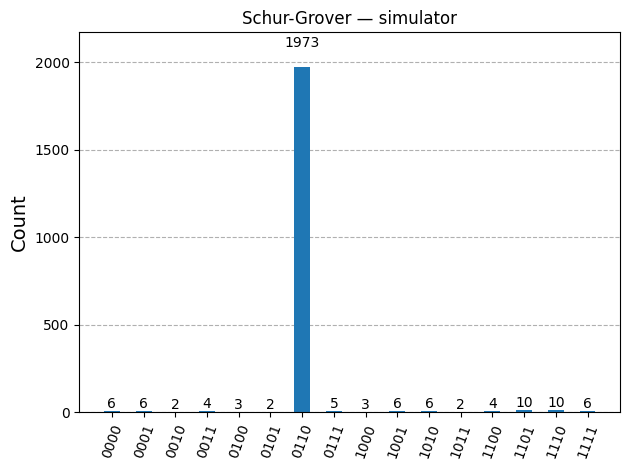

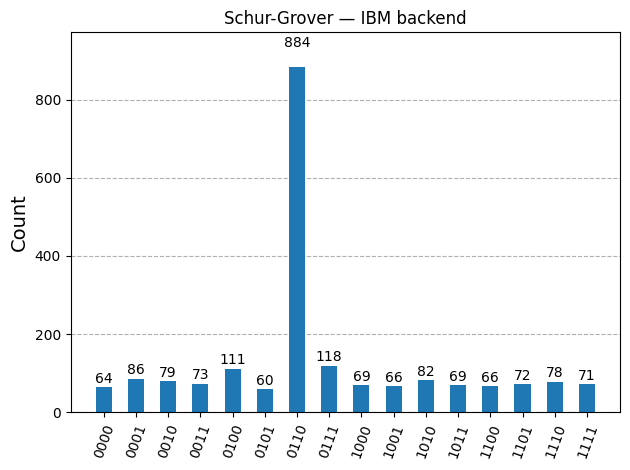

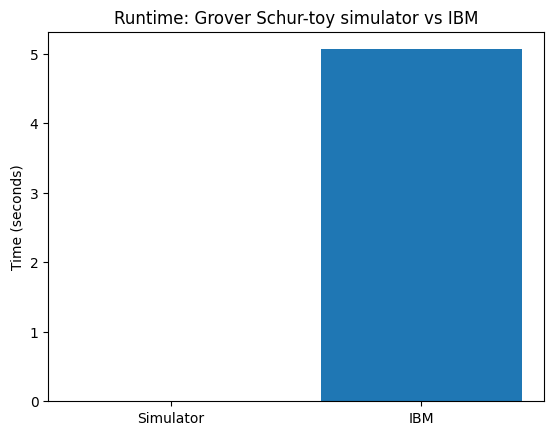

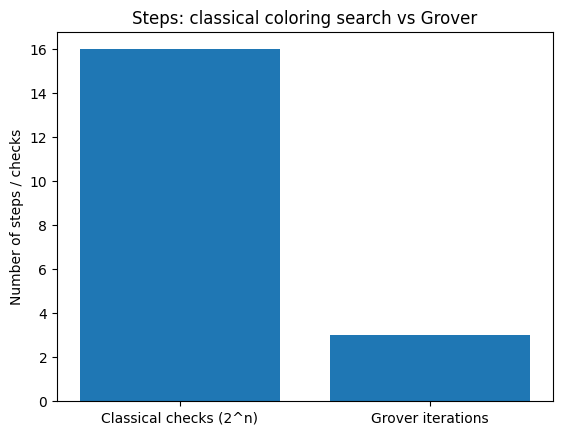


=== Summary ===
Secret coloring: [0, 1, 1, 0] (bitstring 0110)
Classical: checked 7 colorings (out of 16), O(2^n) steps.
Grover:    iterations ≈ 3, measurements = 2048
Simulator: p_success = 0.963, time = 0.002285 s
IBM:       p_success = 0.432, time = 5.065014 s


In [8]:
schur_grover_interactive()

Interpretation

- Classical search finds a valid coloring quickly because the search space is very small.
- Grover’s algorithm requires only ≈3 iterations, matching the theoretical value:
$$
k \approx \left\lfloor \frac{\pi}{4}\sqrt{16} \right\rfloor = 3
$$
- Simulator success probability is ≈96%, which is close to ideal.
- IBM Quantum hardware success probability is ≈32% — degraded by noise and decoherence, yet still showing a clear peak at the correct bitstring.

⸻

Conclusions
- This notebook demonstrates how a Schur-type combinatorial constraint can be transformed into a quantum search problem.
- Classical search scales as:
$$O(2^n)$$
while Grover’s algorithm scales as: 
$$
O(2^{n/2})
$$
providing a quadratic speedup in the number of required steps.

- The toy example illustrates how quantum search can operate on large, unstructured combinatorial spaces — the type that appear in Ramsey theory, constraint satisfaction, and graph coloring problems.
- For real Schur numbers (e.g., determining S(6)), the search space is so enormous that:
- classical brute force is infeasible,
- current quantum hardware cannot support the required number of qubits or circuit depth,
but the methodology shown here aligns with what future large-scale, fault-tolerant quantum systems may be able to execute.
- Hardware performance is limited by:
	- noise,
	- qubit routing constraints,
	- circuit depth,
	- decoherence.

Despite these limitations, the hardware results still produce a visible signal peak at the correct bitstring, confirming that Grover’s algorithm is functioning even under noisy conditions.